In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
sns.set_style('whitegrid')
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.0})

# Return Forecasting: Read Historical Daily Yen Futures Data
In this notebook, you will load historical Dollar-Yen exchange rate futures data and apply time series analysis and modeling to determine whether there is any predictable behavior.

In [2]:
# Futures contract on the Yen-dollar exchange rate:
# This is the continuous chain of the futures contracts that are 1 month to expiration
yen_futures = pd.read_csv(
    Path("yen.csv"), index_col="Date", infer_datetime_format=True, parse_dates=True
)
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1976-08-02,3398.0,3401.0,3398.0,3401.0,NaN,3401.0,2.0,1.0
1976-08-03,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-04,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-05,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-06,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0


In [3]:
# Trim the dataset to begin on January 1st, 1990
yen_futures = yen_futures.loc["1990-01-01":, :]
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1990-01-02,6954.0,6954.0,6835.0,6847.0,NaN,6847.0,48336.0,51473.0
1990-01-03,6877.0,6910.0,6865.0,6887.0,NaN,6887.0,38206.0,53860.0
1990-01-04,6937.0,7030.0,6924.0,7008.0,NaN,7008.0,49649.0,55699.0
1990-01-05,6952.0,6985.0,6942.0,6950.0,NaN,6950.0,29944.0,53111.0
1990-01-08,6936.0,6972.0,6936.0,6959.0,NaN,6959.0,19763.0,52072.0


 # Return Forecasting: Initial Time-Series Plotting

 Start by plotting the "Settle" price. Do you see any patterns, long-term and/or short?

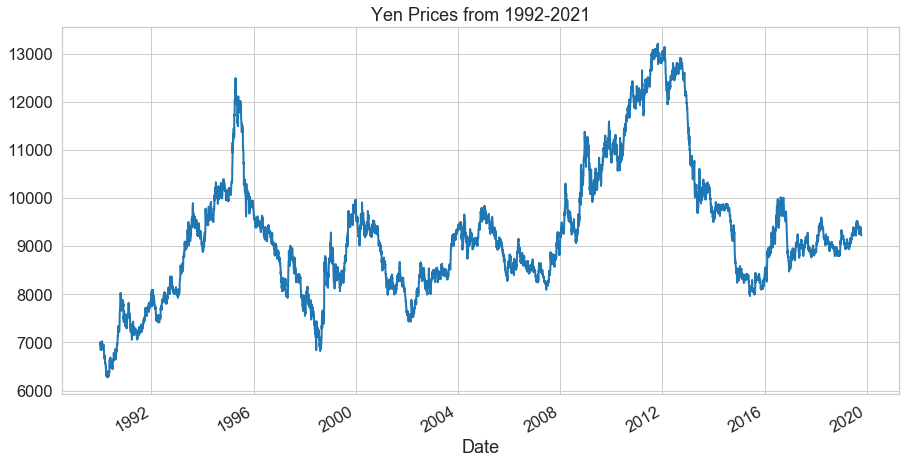

In [4]:
# Plot just the "Settle" column from the dataframe:
yen_futures.Settle.plot(
    title = 'Yen Prices from 1992-2021',
    figsize = (15,7.5)
)

---

# Decomposition Using a Hodrick-Prescott Filter

 Using a Hodrick-Prescott Filter, decompose the Settle price into a trend and noise.

In [5]:
import statsmodels.api as sm

# Apply the Hodrick-Prescott Filter by decomposing the "Settle" price into two separate series:
noise, trend = sm.tsa.filters.hpfilter(yen_futures.Settle)

In [6]:
# Create a dataframe of just the settle price, and add columns for "noise" and "trend" series from above:
noise_trend_yen_df = pd.concat([yen_futures.Settle, noise,trend], axis = 'columns')
noise_trend_yen_df.columns = ['Yen_Settle','Yen_Noise','Yen_Trend']
noise_trend_yen_df.head()

,Yen_Settle,Yen_Noise,Yen_Trend
Date,,,
1990-01-02,6847.0,-61.503967,6908.503967
1990-01-03,6887.0,-21.799756,6908.799756
1990-01-04,7008.0,98.942896,6909.057104
1990-01-05,6950.0,40.776052,6909.223948
1990-01-08,6959.0,49.689938,6909.310062


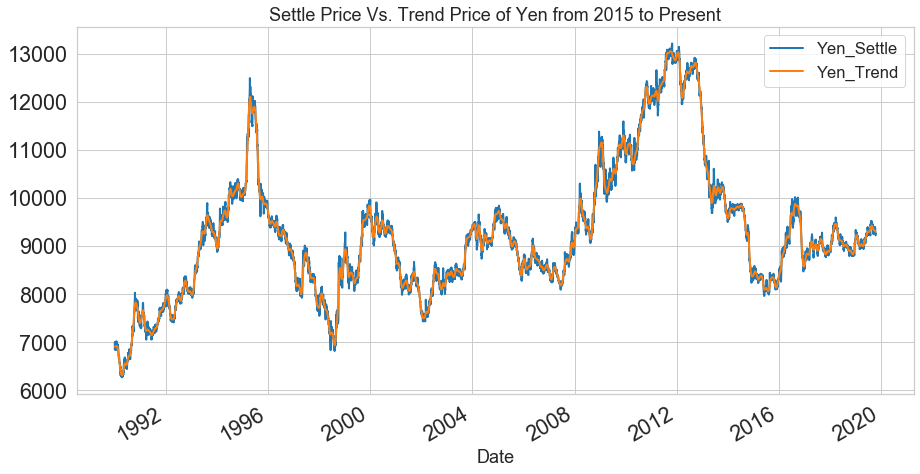

In [7]:
# Plot the Settle Price vs. the Trend for 2015 to the present
noise_trend_yen_df[['Yen_Settle','Yen_Trend']].plot(
    title = 'Settle Price Vs. Trend Price of Yen from 2015 to Present',
    fontsize = 'large',
    figsize = (15,7.5)
)

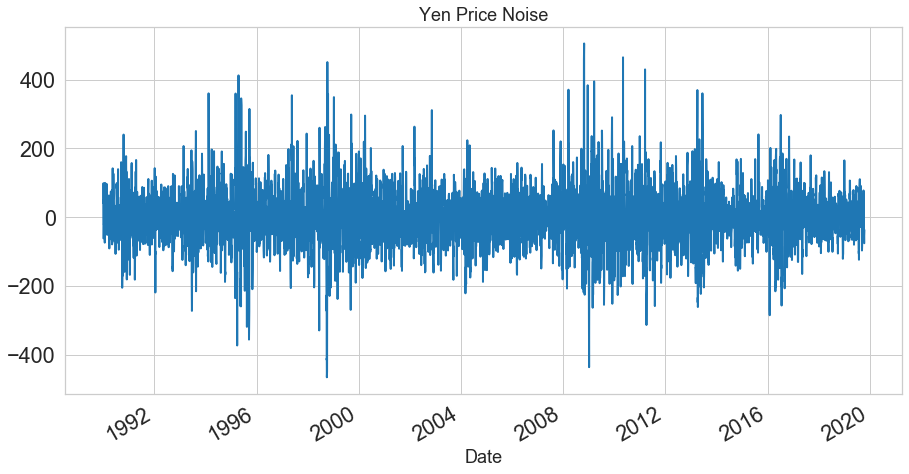

In [8]:
# Plot the Settle Noise
noise_plot = noise.plot(
    title = 'Yen Price Noise',
    fontsize = 'large',
    figsize = (15,7.5)
)

---

# Forecasting Returns using an ARMA Model

Using futures Settle *Returns*, estimate an ARMA model

1. ARMA: Create an ARMA model and fit it to the returns data. Note: Set the AR and MA ("p" and "q") parameters to p=2 and q=1: order=(2, 1).
2. Output the ARMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Plot the 5-day forecast of the forecasted returns (the results forecast from ARMA model)

In [9]:
# Create a series using "Settle" price percentage returns, drop any nan"s, and check the results:
# (Make sure to multiply the pct_change() results by 100)
# In this case, you may have to replace inf, -inf values with np.nan"s
returns = (yen_futures[["Settle"]].pct_change() * 100)
returns = returns.replace(-np.inf, np.nan).dropna()
returns.tail()

,Settle
Date,
2019-10-09,-0.410601
2019-10-10,-0.369458
2019-10-11,-0.564304
2019-10-14,0.151335
2019-10-15,-0.469509


In [10]:
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARMA, ARIMA

# Estimate and ARMA model using statsmodels (use order=(2, 1))
model = ARMA(returns.Settle, order = (2,1))

# Fit the model and assign it to a variable called results
results = model.fit()

/home/tyler/anaconda3/envs/analysis/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


In [11]:
# Output model summary results:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                 Settle   No. Observations:                 7514
Model:                     ARMA(2, 1)   Log Likelihood               -7894.071
Method:                       css-mle   S.D. of innovations              0.692
Date:                Sun, 07 Mar 2021   AIC                          15798.142
Time:                        03:08:08   BIC                          15832.765
Sample:                             0   HQIC                         15810.030
                                                                              
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0063      0.008      0.804      0.422      -0.009       0.022
ar.L1.Settle    -0.3062      1.277     -0.240      0.811      -2.810       2.197
ar.L2.Settle    -0.0019      0.019     -0.099      0.921      -0.040       0.036
ma.L1.Settle     0.2946      1.277      0.231      0.818      -2.209       2.798
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -3.3352           +0.0000j            3.3352            0.5000
AR.2         -157.2046           +0.0000j          157.2046            0.5000
MA.1           -3.3942           +0.0000j            3.3942            0.5000
-----------------------------------------------------------------------------
"""

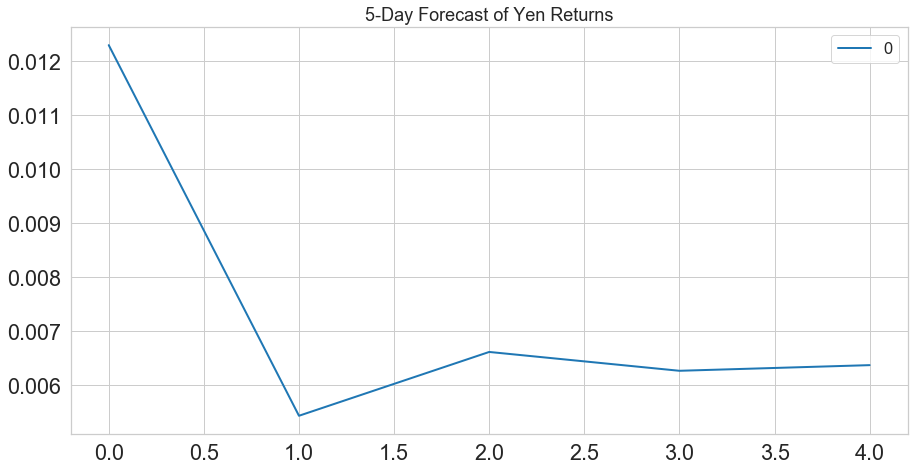

In [12]:
# Plot the 5 Day Returns Forecast
forecast = pd.DataFrame(results.forecast(steps =5)[0]).plot(
    title="5-Day Forecast of Yen Returns",
    figsize = (15,7.5),
    fontsize = 'large'
    )
forecast

# Alternative ARMA Analysis

In [87]:
best_order = []
for p in range(1,11):
    for q in range(1,11):
        order = (p,q)
        # Estimate and ARMA model using statsmodels (use order=(2, 1))
        model = ARMA(returns.Settle, order = order)

        # Fit the model and assign it to a variable called results
        results = model.fit()
        aic = results.aic
        order_results = [aic,order]
        best_order.append(order_results)
        print(order_results)

r/anaconda3/envs/analysis/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warn('Inverting hessian failed, no bse or cov_params '
/home/tyler/anaconda3/envs/analysis/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/home/tyler/anaconda3/envs/analysis/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
[15785.483896213234, (7, 7)]
/home/tyler/anaconda3/envs/analysis/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warn('Inverting

In [89]:
sorted(best_order)[0]

[15775.437677097983, (6, 7)]

In [90]:
model = ARMA(returns.Settle, order = (6,7))

# Fit the model and assign it to a variable called results
results = model.fit()
results.summary()

/home/tyler/anaconda3/envs/analysis/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/home/tyler/anaconda3/envs/analysis/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warn('Inverting hessian failed, no bse or cov_params '
/home/tyler/anaconda3/envs/analysis/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                 Settle   No. Observations:                 7514
Model:                     ARMA(6, 7)   Log Likelihood               -7872.719
Method:                       css-mle   S.D. of innovations              0.689
Date:                Sun, 07 Mar 2021   AIC                          15775.438
Time:                        05:00:25   BIC                          15879.306
Sample:                             0   HQIC                         15811.102
                                                                              
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0045      0.008      0.573      0.567      -0.011       0.020
ar.L1.Settle    -0.3277      0.002   -210.873      0.000      -0.331      -0.325
ar.L2.Settle     0.3026      0.002    186.223      0.000       0.299       0.306
ar.L3.Settle     0.2587      0.002    159.718      0.000       0.255       0.262
ar.L4.Settle     0.3047      0.002    191.880      0.000       0.302       0.308
ar.L5.Settle    -0.3274      0.002   -192.086      0.000      -0.331      -0.324
ar.L6.Settle    -0.9935      0.002   -637.506      0.000      -0.997      -0.990
ma.L1.Settle     0.3166      0.012     27.216      0.000       0.294       0.339
ma.L2.Settle    -0.3128      0.004    -84.996      0.000      -0.320      -0.306
ma.L3.Settle    -0.2559      0.004    -69.312      0.000      -0.263      -0.249
ma.L4.Settle    -0.3068      0.003   -118.403      0.000      -0.312      -0.302
ma.L5.Settle     0.3309      0.004     88.402      0.000       0.324       0.338
ma.L6.Settle     0.9962      0.004    266.834      0.000       0.989       1.003
ma.L7.Settle    -0.0107      0.012     -0.920      0.358      -0.033       0.012
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.8989           -0.4407j            1.0011           -0.0725
AR.2            0.8989           +0.4407j            1.0011            0.0725
AR.3           -0.1382           -0.9910j            1.0006           -0.2721
AR.4           -0.1382           +0.9910j            1.0006            0.2721
AR.5           -0.9255           -0.3827j            1.0015           -0.4376
AR.6           -0.9255           +0.3827j            1.0015            0.4376
MA.1           -0.9249           -0.3805j            1.0001           -0.4379
MA.2           -0.9249           +0.3805j            1.0001            0.4379
MA.3           -0.1375           -0.9905j            1.0000           -0.2720
MA.4           -0.1375           +0.9905j            1.0000            0.2720
MA.5            0.8986           -0.4388j            1.0000           -0.0723
MA.6            0.8986           +0.4388j            1.0000            0.0723
MA.7           93.7772           -0.0000j           93.7772           -0.0000
-----------------------------------------------------------------------------
"""

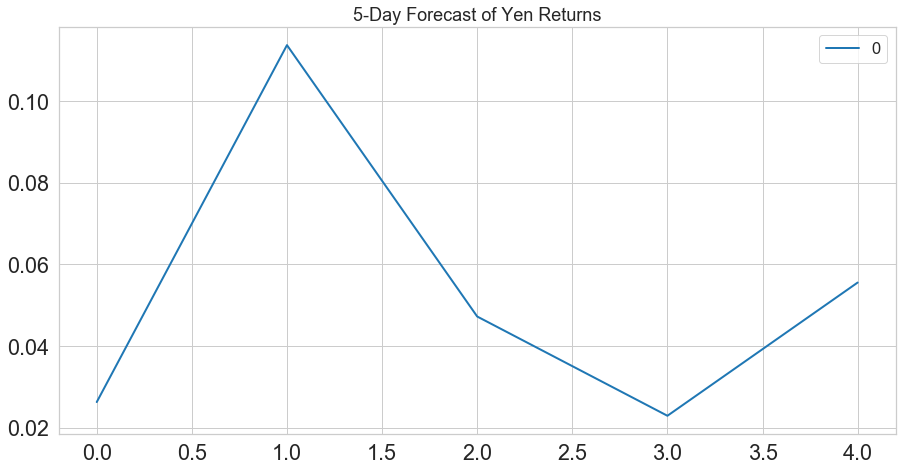

In [93]:
# Plot the 5 Day Returns Forecast
forecast1 = pd.DataFrame(results.forecast(steps =5)[0]).plot(
    title="5-Day Forecast of Yen Returns",
    figsize = (15,7.5),
    fontsize = 'large'
    )
forecast1

 1. Using the *raw* Yen **Settle Price**, estimate an ARIMA model.
     1. Set P=5, D=1, and Q=1 in the model (e.g., ARIMA(df, order=(5,1,1))
     2. P= # of Auto-Regressive Lags, D= # of Differences (this is usually =1), Q= # of Moving Average Lags
 2. Output the ARIMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
 3. Construct a 5 day forecast for the Settle Price. What does the model forecast will happen to the Japanese Yen in the near term?

In [13]:
from statsmodels.tsa.arima_model import ARIMA

# Estimate and ARIMA Model:
# Hint: ARIMA(df, order=(p, d, q))
model = ARIMA(yen_futures.Settle, order = (5,1,1))

# Fit the model
results = model.fit()

/home/tyler/anaconda3/envs/analysis/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/home/tyler/anaconda3/envs/analysis/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


In [14]:
# Output model summary results:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:               D.Settle   No. Observations:                 7514
Model:                 ARIMA(5, 1, 1)   Log Likelihood              -41944.619
Method:                       css-mle   S.D. of innovations             64.281
Date:                Sun, 07 Mar 2021   AIC                          83905.238
Time:                        03:08:10   BIC                          83960.635
Sample:                             1   HQIC                         83924.259
                                                                              
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.3161      0.700      0.452      0.652      -1.056       1.688
ar.L1.D.Settle     0.2823      0.699      0.404      0.686      -1.088       1.652
ar.L2.D.Settle     0.0007      0.016      0.043      0.966      -0.030       0.032
ar.L3.D.Settle    -0.0126      0.012     -1.032      0.302      -0.037       0.011
ar.L4.D.Settle    -0.0137      0.015     -0.889      0.374      -0.044       0.016
ar.L5.D.Settle    -0.0012      0.018     -0.064      0.949      -0.036       0.034
ma.L1.D.Settle    -0.2974      0.699     -0.425      0.670      -1.667       1.072
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.8919           -1.3784j            2.3408           -0.1002
AR.2            1.8919           +1.3784j            2.3408            0.1002
AR.3           -2.2707           -3.0203j            3.7786           -0.3526
AR.4           -2.2707           +3.0203j            3.7786            0.3526
AR.5          -11.0912           -0.0000j           11.0912           -0.5000
MA.1            3.3628           +0.0000j            3.3628            0.0000
-----------------------------------------------------------------------------
"""

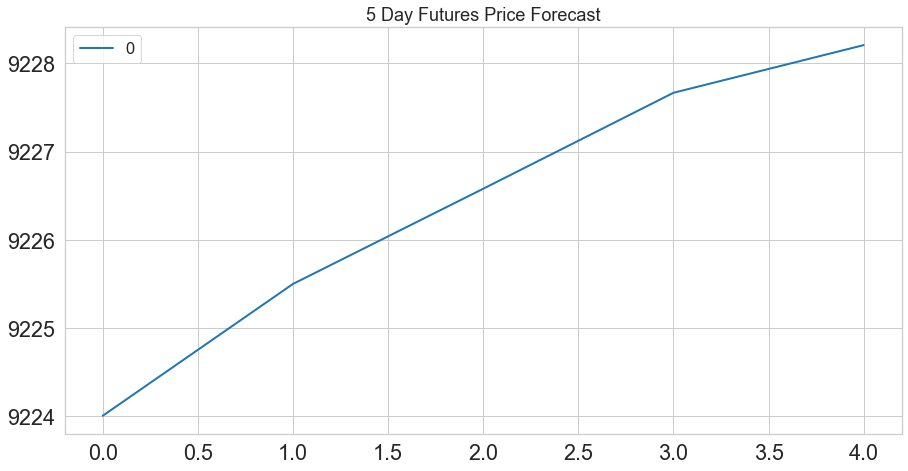

In [15]:
# Plot the 5 Day Price Forecast
forecast = pd.DataFrame(results.forecast(steps = 5)[0]).plot(
    title = '5 Day Futures Price Forecast',
    figsize = (15,7.5),
    fontsize = 'large'
)

---

# Volatility Forecasting with GARCH

Rather than predicting returns, let's forecast near-term **volatility** of Japanese Yen futures returns. Being able to accurately predict volatility will be extremely useful if we want to trade in derivatives or quantify our maximum loss.
 
Using futures Settle *Returns*, estimate an GARCH model

1. GARCH: Create an GARCH model and fit it to the returns data. Note: Set the parameters to p=2 and q=1: order=(2, 1).
2. Output the GARCH summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Plot the 5-day forecast of the volatility.

In [16]:
from arch import arch_model
from statsmodels.tsa.stattools import adfuller

In [43]:
# Estimate a GARCH model:
model = arch_model(
    returns.Settle,
    mean = "Zero", 
    vol="GARCH", 
    p=2, 
    q=1)# Got this part from the documentation. Seemed to lower the AIC.

# Fit the model
results = model.fit(update_freq = 5)

Iteration:      5,   Func. Count:     34,   Neg. LLF: 7479.053903182994
Iteration:     10,   Func. Count:     62,   Neg. LLF: 7461.935968239088
Optimization terminated successfully    (Exit mode 0)
            Current function value: 7461.927640079675
            Iterations: 14
            Function evaluations: 81
            Gradient evaluations: 14


In [68]:
best_orders = []
for p in range(1,16):
    for q in range(1,16):
        model = arch_model(
            returns.Settle,
            mean = "Zero",
            vol = "GARCH",
            p = p,
            q = q
            )

        results = model.fit(update_freq = 5)
        aic = results.aic
        order = [aic, (p,q)]
        best_orders.append(order)
        print(f'\n\nThe AIC and ORDER: {order}\n\n')

   Neg. LLF: 7419.022805539045
Iteration:     35,   Func. Count: 1.06e+03,   Neg. LLF: 7418.996698277249
Optimization terminated successfully    (Exit mode 0)
            Current function value: 7418.996697862873
            Iterations: 36
            Function evaluations: 1088
            Gradient evaluations: 36


The AIC and ORDER: [14893.993395725745, (13, 14)]


Iteration:      5,   Func. Count:    161,   Neg. LLF: 8261.965498892989
Iteration:     10,   Func. Count:    319,   Neg. LLF: 7839.843183742025
Iteration:     15,   Func. Count:    477,   Neg. LLF: 7454.795574879096
Iteration:     20,   Func. Count:    633,   Neg. LLF: 7442.821669568645
Iteration:     25,   Func. Count:    787,   Neg. LLF: 7422.858147028544
Iteration:     30,   Func. Count:    941,   Neg. LLF: 7418.999497859074
Iteration:     35,   Func. Count: 1.09e+03,   Neg. LLF: 7418.996698111097
Optimization terminated successfully    (Exit mode 0)
            Current function value: 7418.996698111097
            Iter

In [69]:
sorted(best_orders)[0]

[14874.80410353642, (6, 9)]

In [84]:
model = arch_model(
    returns.Settle,
    mean = "Zero", 
    vol="GARCH", 
    p=6, 
    q=9)# Got this part from the documentation. Seemed to lower the AIC.

# Fit the model
results = model.fit(update_freq = 5)

Iteration:      5,   Func. Count:     92,   Neg. LLF: 7569.28449609533
Iteration:     10,   Func. Count:    182,   Neg. LLF: 10369.41081030212
Iteration:     15,   Func. Count:    274,   Neg. LLF: 7588.777184414744
Iteration:     20,   Func. Count:    365,   Neg. LLF: 7435.519506144225
Iteration:     25,   Func. Count:    453,   Neg. LLF: 7421.402056762409
Optimization terminated successfully    (Exit mode 0)
            Current function value: 7421.40205176821
            Iterations: 27
            Function evaluations: 486
            Gradient evaluations: 27


In [85]:
adfuller(returns.Settle)

(-87.67736238539413,
 0.0,
 0,
 7513,
 {'1%': -3.4312206955500963,
  '5%': -2.8619247816139843,
  '10%': -2.5669748148389813},
 15724.766827334091)

In [86]:
# Summarize the model results
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - GARCH Model Results                        
==============================================================================
Dep. Variable:                 Settle   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -7421.40
Distribution:                  Normal   AIC:                           14874.8
Method:            Maximum Likelihood   BIC:                           14985.6
                                        No. Observations:                 7514
Date:                Sun, Mar 07 2021   Df Residuals:                     7514
Time:                        03:22:07   Df Model:                            0
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega          0.0218  2.063e-02      1.054      0.292 [-1.868e-02,6.218e-02]
alpha[1]       0.0944  2.325e-02      4.062  4.875e-05    [4.887e-02,  0.140]
alpha[2]       0.0314  4.697e-02      0.669      0.503   [-6.063e-02,  0.123]
alpha[3]       0.0162  4.017e-02      0.404      0.686 [-6.248e-02,9.497e-02]
alpha[4]       0.0169  6.666e-02      0.253      0.800      [ -0.114,  0.148]
alpha[5]   4.5798e-03  6.583e-02  6.957e-02      0.945      [ -0.124,  0.134]
alpha[6]       0.0413  4.513e-02      0.914      0.360   [-4.719e-02,  0.130]
beta[1]        0.0000      0.424      0.000      1.000      [ -0.831,  0.831]
beta[2]        0.0000      0.284      0.000      1.000      [ -0.557,  0.557]
beta[3]        0.0000      0.577      0.000      1.000      [ -1.131,  1.131]
beta[4]        0.0000      0.436      0.000      1.000      [ -0.855,  0.855]
beta[5]        0.2062      0.289      0.713      0.476      [ -0.360,  0.773]
beta[6]        0.0000      0.228      0.000      1.000      [ -0.447,  0.447]
beta[7]        0.0640      0.289      0.221      0.825      [ -0.503,  0.631]
beta[8]        0.0000      0.475      0.000      1.000      [ -0.932,  0.932]
beta[9]        0.4818      0.164      2.932  3.371e-03      [  0.160,  0.804]
=============================================================================

Covariance estimator: robust
"""

In [76]:
# Find the last day of the dataset
last_day = returns.index.max().strftime('%Y-%m-%d')
last_day

'2019-10-15'

In [77]:
# Create a 5 day forecast of volatility
forecast_horizon = 5
# Start the forecast using the last_day calculated above
forecasts = results.forecast(start=last_day, horizon=forecast_horizon)

In [78]:
# Annualize the forecast
intermediate = np.sqrt(forecasts.variance.dropna() * 252)
intermediate.head()

,h.1,h.2,h.3,h.4,h.5
Date,,,,,
2019-10-15,7.699563,7.612128,7.418773,7.733817,7.50975


In [79]:
# Transpose the forecast so that it is easier to plot
final = intermediate.dropna().T
final.head()

Date,2019-10-15
h.1,7.699563
h.2,7.612128
h.3,7.418773
h.4,7.733817
h.5,7.509750


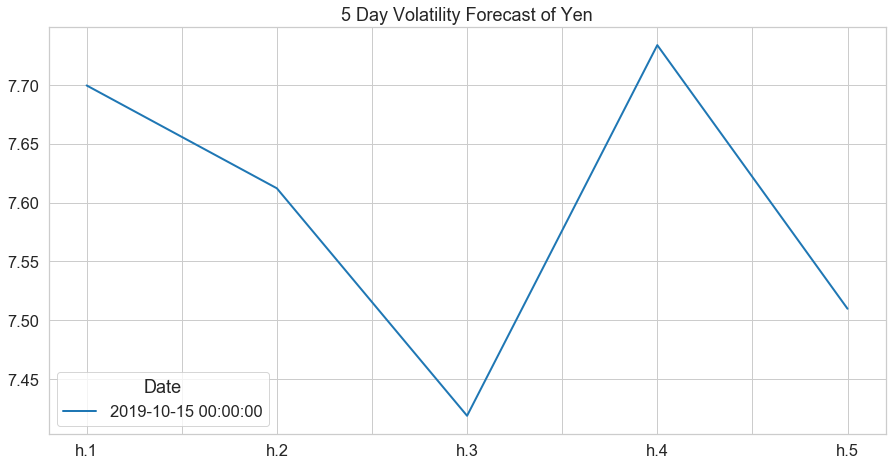

In [80]:
# Plot the final forecast
final.plot(
    title = '5 Day Volatility Forecast of Yen',
    figsize = (15, 7.5)
)

---

# Conclusions

Based on your time series analysis, would you buy the yen now?

Is the risk of the yen expected to increase or decrease?

Based on the model evaluation, would you feel confident in using these models for trading?

### In my analysis, the ARIMA, ARMA, and GARCH models suggest that the price of Yen is to go up, the returns are to go down but remain positive, and the volatility is to go up in the next few days respectively.
It seems as though the ARMA and ARIMA model are in accordance as to the direction of the stock; the stock is likely to go upwards in price. The returns of an asset become diminished by each dollar gain in value (Eg. $1 - $2 = 100%; whereas $2 - $3 = 50%). So on a graph, even though returns look like they are falling, since they are still positive, I conclude the trend would still be upward overall.

The risk of the yen is expected to fluctuate. The graph makes it look like the fluctuation will be severe. However, when the scale of the graph is taken into account, it is actually not that bad. (min ~7.3 & max ~7.8)

Based off the given order values used in modeling, I would say that the stock is a good buy and would do so. As far as the model results are concerned, I would like to see a higher log probability and lower AIC/BIC to feel more confident in my decision. Or at the very least, I would like to 1) train the model then test it to see how it perfoms on unseen data, or 2) know that there is not another model perform better.